# Applied ML in Production

## Annotation

In [1]:
from collections import Counter, OrderedDict
import ipywidgets as widgets
import itertools
import json
import pandas as pd
from urllib.request import urlopen

In [2]:
# Load projects
url = "https://raw.githubusercontent.com/madewithml/datasets/main/projects.json"
projects = json.loads(urlopen(url).read())
print (json.dumps(projects[-305], indent=2))

{
  "id": 324,
  "title": "AdverTorch",
  "description": "A Toolbox for Adversarial Robustness Research",
  "tags": [
    "code",
    "library",
    "security",
    "adversarial-learning",
    "adversarial-attacks",
    "adversarial-perturbations"
  ]
}


In [3]:
# Load tags
url = "https://raw.githubusercontent.com/madewithml/datasets/main/tags.json"
tags_dict = OrderedDict(json.loads(urlopen(url).read()))
print (f"{len(tags_dict)} tags")

400 tags


In [4]:
@widgets.interact(tag=list(tags_dict.keys()))
def display_tag_details(tag='question-answering'):
    print (json.dumps(tags_dict[tag], indent=2))

interactive(children=(Dropdown(description='tag', index=283, options=('3d', 'action-localization', 'action-rec…

In [5]:
# Create dataframe
df = pd.DataFrame(projects)
print (f"{len(df)} projects")
df.head(5)

2032 projects


,id,title,description,tags
0,2438,How to Deal with Files in Google Colab: What Y...,How to supercharge your Google Colab experienc...,"[article, google-colab, colab, file-system]"
1,2437,Rasoee,A powerful web and mobile application that ide...,"[api, article, code, dataset, paper, research,..."
2,2436,Machine Learning Methods Explained (+ Examples),Most common techniques used in data science pr...,"[article, deep-learning, machine-learning, dim..."
3,2435,Top “Applied Data Science” Papers from ECML-PK...,Explore the innovative world of Machine Learni...,"[article, deep-learning, machine-learning, adv..."
4,2434,OpenMMLab Computer Vision,MMCV is a python library for CV research and s...,"[article, code, pytorch, library, 3d, computer..."


In [6]:
# Input
df['text'] = df.title + " " + df.description

In [7]:
def filter(l, include=[], exclude=[]):
    """Filter a list using inclusion and exclusion lists of items."""
    filtered = [item for item in l if item in include and item not in exclude]
    return filtered

In [8]:
# Inclusion/exclusion criteria for tags
include = list(tags_dict.keys())
exclude = ['machine-learning', 'deep-learning',  'data-science',
           'neural-networks', 'python', 'r', 'visualization',
           'natural-language-processing', 'computer-vision']

In [9]:
# Filter tags for each project
df.tags = df.tags.apply(filter, include=include, exclude=exclude)
tags = Counter(itertools.chain.from_iterable(df.tags.values))

In [10]:
@widgets.interact(min_tag_freq=(0, tags.most_common()[0][1]))
def separate_tags_by_freq(min_tag_freq=30):
    tags_above_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] >= min_tag_freq)
    tags_below_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] < min_tag_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(5))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-5:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(5))

interactive(children=(IntSlider(value=30, description='min_tag_freq', max=258), Output()), _dom_classes=('widg…

In [11]:
# Filter tags that have fewer than <min_tag_freq> occurances
min_tag_freq = 30
tags_above_freq = Counter(tag for tag in tags.elements() 
                          if tags[tag] >= min_tag_freq)
df.tags = df.tags.apply(filter, include=list(tags_above_freq.keys()))

In [12]:
# Remove projects with no more remaining relevant tags
df = df[df.tags.map(len) > 0]
print (f"{len(df)} projects")

1239 projects


## Exploratory Data Analysis (EDA)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
warnings.filterwarnings("ignore")

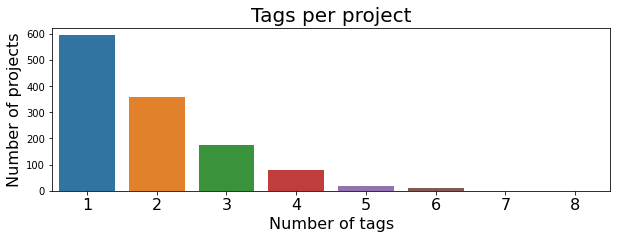

In [14]:
# Number of tags per project
num_tags_per_project = [len(tags) for tags in df.tags]
num_tags, num_projects = zip(*Counter(num_tags_per_project).items())
plt.figure(figsize=(10, 3))
ax = sns.barplot(list(num_tags), list(num_projects))
plt.title("Tags per project", fontsize=20)
plt.xlabel("Number of tags", fontsize=16)
ax.set_xticklabels(range(1, len(num_tags)+1), rotation=0, fontsize=16)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

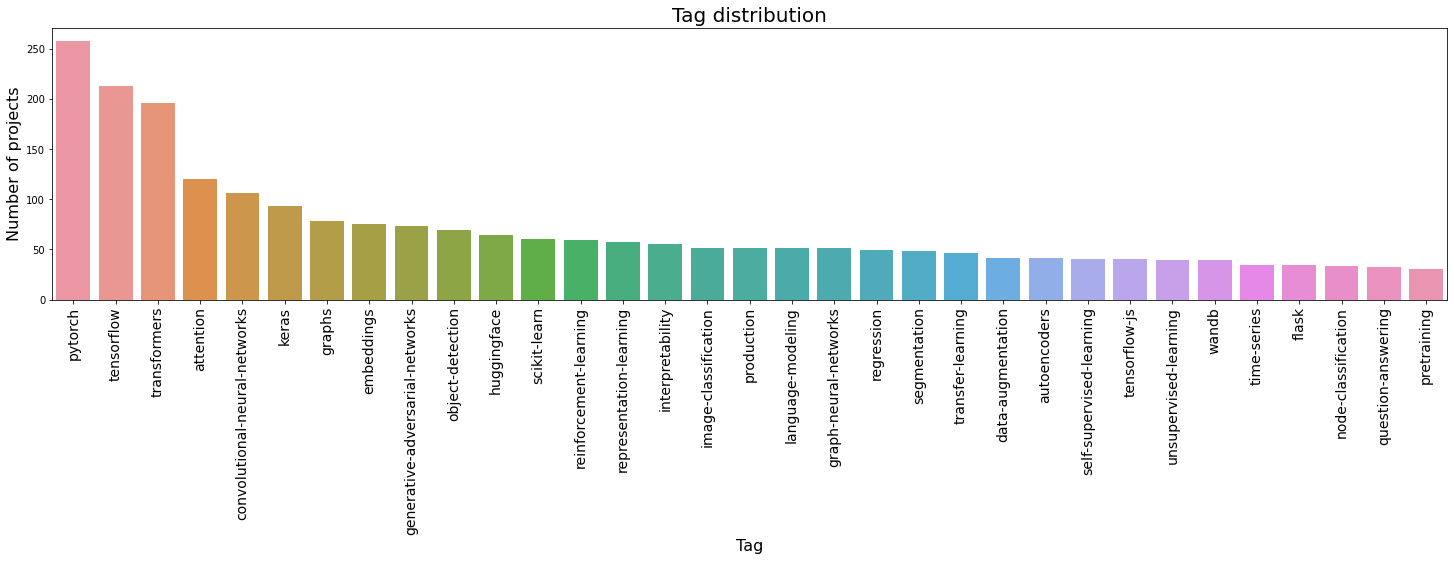

In [15]:
# Distribution of tags
all_tags = list(itertools.chain.from_iterable(df.tags.values))
tags, tag_counts = zip(*Counter(all_tags).most_common())
plt.figure(figsize=(25, 5))
ax = sns.barplot(list(tags), list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

In [16]:
@widgets.interact(tag=list(tags))
def display_word_cloud(tag='pytorch'):
    # Plot word clouds top top tags
    plt.figure(figsize=(15, 5))
    subset = df[df.tags.apply(lambda tags: tag in tags)]
    text = subset.text.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color='black', collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis('off')
    plt.imshow(cloud)

interactive(children=(Dropdown(description='tag', options=('pytorch', 'tensorflow', 'transformers', 'attention…

## Encoding

In [17]:
import numpy as np
import random

In [18]:
# Set seeds for reproducability
seed = 1234
np.random.seed(seed)
random.seed(seed)

In [19]:
# Shuffle
df = df.sample(frac=1).reset_index(drop=True)

In [20]:
# Get data
X = df.text.to_numpy()
y = df.tags

In [21]:
X, y

(array(['Haystack — Neural Question Answering At Scale Scaling Question Answering models to find answers in large document stores via retriever and reader approach.',
        'Interpretable Machine Learning A guide for making black box models explainable.',
        'ONNX Transformers Accelerated NLP pipelines for fast inference 🚀 on CPU. Built with 🤗 Transformers and ONNX runtime.',
        ...,
        'Attention? Attention! In this post, we are gonna look into how attention was invented, and various attention mechanisms and models, such as transformer and SNAIL.',
        'Time Series Forecasting with TensorFlow.js Machine learning is becoming increasingly popular these days and a growing number of the world’s population see it is as a magic crystal ball: predicting when a',
        'Digit Classification of MNIST Dataset using Tensorflow Lite Created an Android App which classifies and reconizes digit of MNIST dataset using Tensorflow-Lite and Keras.Trained the model on Laptop and de

We'll be writing our own LabelEncoder which is based on scikit-learn's [implementation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). 

In [22]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(list(itertools.chain.from_iterable(y)))
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def transform(self, y):
        y_one_hot = np.zeros((len(y), len(self.class_to_index)), dtype=int)
        for i, item in enumerate(y):
            for class_ in item:
                y_one_hot[i][self.class_to_index[class_]] = 1
        return y_one_hot

    def inverse_transform(self, y):
        classes = []
        for i, item in enumerate(y):
            indices = np.where(item == 1)[0]
            classes.append([self.index_to_class[index] for index in indices])
        return classes

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [23]:
# Binarize y
label_encoder = LabelEncoder()
label_encoder.fit(y)

In [24]:
label_encoder.class_to_index

{'attention': 0,
 'autoencoders': 1,
 'convolutional-neural-networks': 2,
 'data-augmentation': 3,
 'embeddings': 4,
 'flask': 5,
 'generative-adversarial-networks': 6,
 'graph-neural-networks': 7,
 'graphs': 8,
 'huggingface': 9,
 'image-classification': 10,
 'interpretability': 11,
 'keras': 12,
 'language-modeling': 13,
 'node-classification': 14,
 'object-detection': 15,
 'pretraining': 16,
 'production': 17,
 'pytorch': 18,
 'question-answering': 19,
 'regression': 20,
 'reinforcement-learning': 21,
 'representation-learning': 22,
 'scikit-learn': 23,
 'segmentation': 24,
 'self-supervised-learning': 25,
 'tensorflow': 26,
 'tensorflow-js': 27,
 'time-series': 28,
 'transfer-learning': 29,
 'transformers': 30,
 'unsupervised-learning': 31,
 'wandb': 32}

In [25]:
label_encoder.transform([["attention", "data-augmentation"]])

array([[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
y = label_encoder.transform(y)

## Splitting

**Naive split**

In [27]:
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

In [28]:
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

For simple multiclass classification, you can specify how to stratify the split by adding the [**stratify**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) keyword argument. But our task is multilabel classification, so we'll need to use other techniques to create even splits.

In [29]:
# Split (train)
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size)

In [30]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 867 (0.70)
remaining: 372 (0.30)


In [31]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5)

In [32]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 867 (0.70)
val: 186 (0.15)
test: 186 (0.15)


In [33]:
# Get counts for each class
counts = {}
counts['train_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
counts['val_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
counts['test_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

In [34]:
# View distributions
pd.DataFrame({
    'train': counts['train_counts'],
    'val': counts['val_counts'],
    'test': counts['test_counts']
}).T.fillna(0)

,"(18,)","(15,)","(0,)","(30,)","(26,)","(5,)","(20,)","(1,)","(22,)","(12,)",...,"(21,)","(23,)","(31,)","(8,)","(14,)","(29,)","(32,)","(16,)","(7,)","(19,)"
train,188,48,90,139,149,19,35,25,42,63,...,41,39,23,58,25,24,24,22,41,20
val,30,14,17,31,31,7,5,9,5,10,...,8,9,11,11,4,12,7,7,5,6
test,40,7,13,26,33,8,9,7,10,20,...,10,12,5,9,4,10,8,1,5,6


It's hard to compare these because our train and test proportions are different. Let's see what the distribution looks like once we balance it out. What do we need to multiply our test ratio by so that we have the same amount as our train ratio?

$\alpha * \text{test_size} = \text{train_size}$

$\alpha = \frac{\text{train_size}}{\text{test_size}}$

In [35]:
# Adjust counts across splits
for k in counts['val_counts'].keys():
    counts['val_counts'][k] = int(counts['val_counts'][k] * \
        (train_size/val_size))
for k in counts['test_counts'].keys():
    counts['test_counts'][k] = int(counts['test_counts'][k] * \
        (train_size/test_size))

In [36]:
dist_df = pd.DataFrame({
    'train': counts['train_counts'],
    'val': counts['val_counts'],
    'test': counts['test_counts']
}).T.fillna(0)
dist_df

,"(18,)","(15,)","(0,)","(30,)","(26,)","(5,)","(20,)","(1,)","(22,)","(12,)",...,"(21,)","(23,)","(31,)","(8,)","(14,)","(29,)","(32,)","(16,)","(7,)","(19,)"
train,188,48,90,139,149,19,35,25,42,63,...,41,39,23,58,25,24,24,22,41,20
val,140,65,79,144,144,32,23,42,23,46,...,37,42,51,51,18,56,32,32,23,28
test,186,32,60,121,154,37,42,32,46,93,...,46,56,23,42,18,46,37,4,23,28


$\sigma = \sqrt{\frac{(x - \bar{x})^2}{N}}$

In [37]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

8.277164215186884

Some of these distributions are not great. Let's try and balance this out a bit better.

**Stratified split**

In [38]:
from skmultilearn.model_selection import IterativeStratification

[Iterative stratification](http://scikit.ml/_modules/skmultilearn/model_selection/iterative_stratification.html#IterativeStratification) essentially creates splits while "trying to maintain balanced representation with respect to order-th label combinations". We used to an **order=1** for our iterative split which means we cared about providing representative distribution of each tag across the splits. You should experiment with other order values to see the split distributions especially if it's important that certain combinations of labels are important.

In [39]:
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which 
    'maintains balanced representation with respect 
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

In [40]:
# Get data
X = df.text.to_numpy()
y = df.tags

In [41]:
# Binarize y
label_encoder = LabelEncoder()
label_encoder.fit(y)
y = label_encoder.transform(y)

In [42]:
# Split
X_train, X_, y_train, y_ = iterative_train_test_split(
    X, y, train_size=train_size)
X_val, X_test, y_val, y_test = iterative_train_test_split(
    X_, y_, train_size=0.5)

In [43]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 861 (0.69)
val: 191 (0.15)
test: 187 (0.15)


In [44]:
# Get counts for each class
counts = {}
counts['train_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
counts['val_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
counts['test_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

In [45]:
# Adjust counts across splits
for k in counts['val_counts'].keys():
    counts['val_counts'][k] = int(counts['val_counts'][k] * \
        (train_size/val_size))
for k in counts['test_counts'].keys():
    counts['test_counts'][k] = int(counts['test_counts'][k] * \
        (train_size/test_size))

In [46]:
# View distributions
pd.DataFrame({
    'train': counts['train_counts'],
    'val': counts['val_counts'],
    'test': counts['test_counts']
}).T.fillna(0)

,"(18,)","(12,)","(10,)","(5,)","(11,)","(25,)","(22,)","(29,)","(16,)","(19,)",...,"(28,)","(15,)","(21,)","(32,)","(1,)","(4,)","(14,)","(9,)","(31,)","(27,)"
train,181,65,36,24,38,28,40,32,19,22,...,24,48,41,23,29,52,23,44,27,28
val,177,65,37,23,37,28,32,32,28,23,...,23,46,42,37,28,51,18,56,28,28
test,182,65,32,23,42,28,46,32,23,23,...,23,51,42,37,28,56,28,37,28,28


In [47]:
dist_df = pd.DataFrame({
    'train': counts['train_counts'],
    'val': counts['val_counts'],
    'test': counts['test_counts']
}).T.fillna(0)

In [48]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

1.6858661049274655

## Preprocessing

Certain preprocessing steps are global (don't depend on our dataset) and others are local (constructs are learned from the training splits). For the local, dataset-dependent preprocessing steps, we want to ensure that we split the data first before preprocessing to avoid data leaks. 

We covered splitting first since many preprocessing transformations depend on the training split and our data splits were dependent only on the target labels (tags) which were already cleaned. However, you need to clean your data first before splitting, at least for the features that splitting depends on. So the process is more like: preprocessing (global, cleaning) → splitting → preprocessing (local, transformations).

In [49]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [50]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to /Users/goku/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
def preprocess(text, lower, stem, filters, stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    if lower: 
        text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub(filters, r"", text)
    text = re.sub(' +', ' ', text)  # remove multiple spaces
    text = text.strip()

    # Remove links
    text = re.sub(r'http\S+', '', text)

    # Stemming
    if stem:
        text = " ".join([porter.stem(word) for word in text.split(' ')])

    return text

In [52]:
@widgets.interact(lower=True, stem=False)
def display_preprocessed_text(lower, stem):
    filters = "[!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~]"
    text = "Conditional image generation using Variational Autoencoders and GANs."
    preprocessed_text = preprocess(text=text, lower=lower, stem=stem, filters=filters)
    print (preprocessed_text)    

interactive(children=(Checkbox(value=True, description='lower'), Checkbox(value=False, description='stem'), Ou…

## Augmentation

This is not used in this course so please feel free to skip this section. We'll cover data augmentation (CV, NLP, audio, etc.) as a separate unit course in the future.

In [53]:
!pip install nlpaug==1.1.0 torch==1.6.0 transformers==3.0.2 -q

You should consider upgrading via the '/Users/goku/Documents/madewithml/courses/applied-ml-in-production/repo/venv/bin/python -m pip install --upgrade pip' command.


In [54]:
import nlpaug.augmenter.word as naw

In [55]:
# Load tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action="insert")

In [56]:
text = "Conditional image generation using Variational Autoencoders and GANs."

In [57]:
# Substitutions
augmented_text = substitution.augment(text)
print (augmented_text)

temporal image generation using variational coordinates or loops.


Substitution doesn't seem like a great idea for us because there are certain keywords that provide strong signal for our tags so we don't want to alter those. Also, note that these augmentations are NOT deterministic and will vary every time we run them. Let's try insertion...

In [59]:
# Insertions
augmented_text = insertion.augment(text)
print (augmented_text)

performs conditional nonlinear image generation using variational autoencoders functions and linear gans.


A little better but still quite fragile and now it can potentially insert key words that can influence false positive tags to appear. For now, we'll skip the data augmentation because it's quite fickle and our case is very unique. But we can see how this can be very effective once we can control what type of vocabulary to augment on (ex. don't alter tokens matching or relating to any algorithms and tasks).